In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import os 

import numpy as np

import pandas as pd

from umap import UMAP

from tensorflow.keras.models import load_model

from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, Birch
from hdbscan import HDBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from modules.utils.viz_utils import cluster_inspection

In [3]:
sns.set(font_scale=1.5, style='whitegrid')

## Load objects

In [4]:
extractor = load_model('results\\models\\features_extractor')
estimator = load_model('results\\models\\sentiment_estimator')
decoder = pd.read_pickle('results\\objects\\decoder.pkl')
sentiments_mapper = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative'
}

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\layers\core.py:1002: UserWarning: modules.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [6]:
embeddings = []
sentences = []
padded_sentences = []
sentiments = []
for batch in range(len(os.listdir('data\\inputs'))):
    
    inp_btch = np.load(f'data\\inputs\\{batch}.npy')
    
    embeddings.append(extractor.predict(inp_btch)[:, -1, :])
    sentences.append(inp_btch)
    sentiments.append(estimator.predict(inp_btch)[0].argmax(axis=1))

for btch in sentences:
    
    padded = np.zeros(shape=(btch.shape[0], 120))
    padded[:, 0: (btch.shape[1] -1)] = btch[:, 0: (btch.shape[1] -1)]
    padded_sentences.append(padded)
    
sentences = np.vstack(padded_sentences)
embeddings = np.vstack(embeddings)
sentiments = np.hstack(sentiments)

In [7]:
manifolds = UMAP(n_components=2, n_neighbors=100, verbose=True, n_epochs=500).fit_transform(embeddings)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=500,
     n_neighbors=100, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Sep 22 11:41:50 2020 Finding Nearest Neighbors
Tue Sep 22 11:41:50 2020 Building RP forest with 11 trees
Tue Sep 22 11:41:50 2020 NN descent for 14 iterations
	 0  /  14
	 1  /  14
	 2  /  14
Tue Sep 22 11:42:13 2020 Finished Nearest Neighbor Search
Tue Sep 22 11:42:15 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  

## Simple Predictions

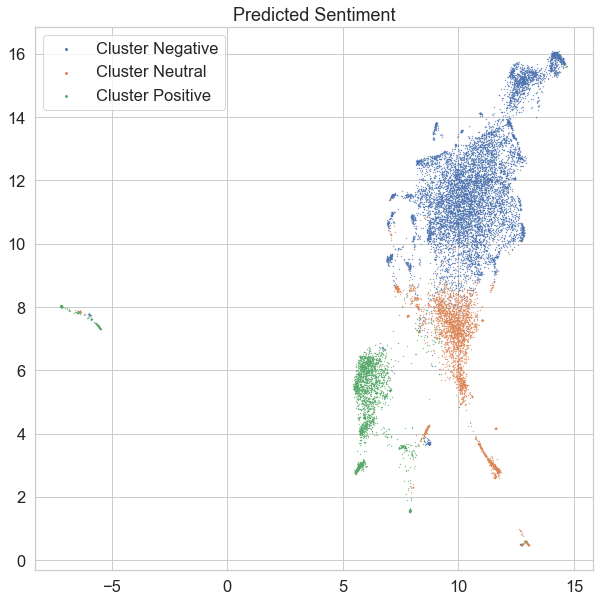


Cluster Negative

Negative : 1.0

* <START> we were not given the option of using our united travelbank in a recent flight booking problems any help in using or recouping these funds

* <START> well being on time is not going to happen now safety does come looks like i have look another flight

* <START> does this process ever end still waiting for the reply since months pathetic

* <START> still no reply to my email sent on february even sent an email asking for acknowledgment that it been recieved

* <START> so how about some help with suggested time i could call to avoid such long wait

* <START> eventually you should approach bags like they get

* <START> no after mins of hold i finally hung up ridiculous wait times can you assist in cancelled flighting

* <START> why ca the gate agent on flight provide an update seriously this is ridiculous how long people have been

* <START> aa was also over an hour late flight to depart ohare and now we have no luggage not happy standing in a 

In [8]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    np.vectorize(sentiments_mapper.get)(sentiments), 
    title='Predicted Sentiment',
    embedding=embeddings,
    decoder=decoder,
    pad=0,
    s=0.1
)

## Clustering With K-means

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


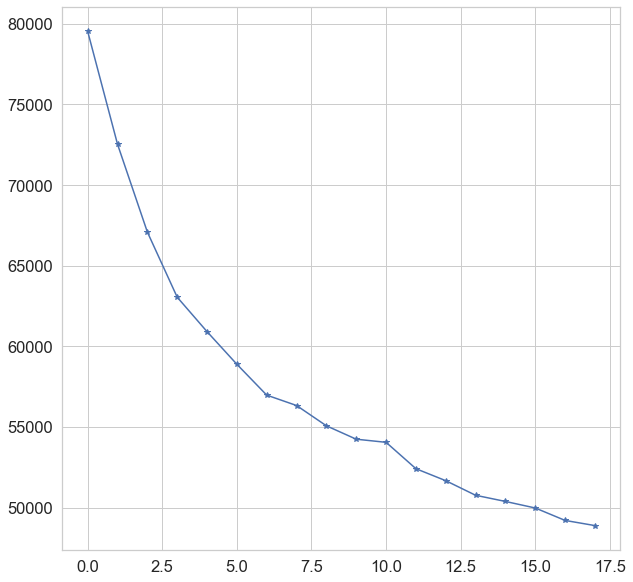

In [9]:
inertias=[]
for k in range(2, 20):
    
    print(k)
    clusterer= MiniBatchKMeans(k, n_init=100)
    clusterer.fit(embeddings)
    inertias.append(clusterer.inertia_)
    
plt.figure(figsize=(10, 10))
plt.plot(inertias, marker='*')
plt.show()

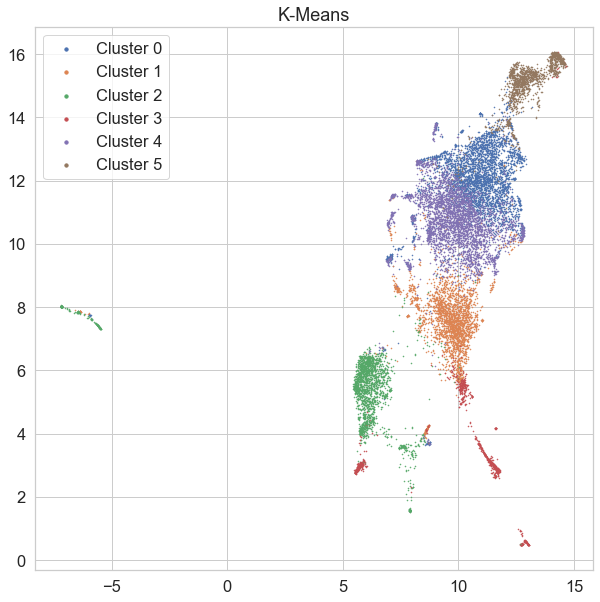


Cluster 0

Negative : 0.998
Positive : 0.002

* <START> united ceo has decided to outsource and or push out more and more of their skilled and loyal of

* <START> really appreciate the great customer service one of your service agents just hung up on me when asking legitimate

* <START> ruth was very helpful in us to punta cana when dulles connection failed other not so


Cluster 1

Negative : 0.121
Neutral : 0.863
Positive : 0.016

* <START> unfortunately i do even have that my phone died before o had a chance to grab it it was from oma to san

* <START> i will dm you

* <START> i on standby for my connecting flight on the list nudgenudge i told there are four slots open save it for me


Cluster 2

Negative : 0.008
Neutral : 0.021
Positive : 0.972

* <START> that makes two of us lol

* <START> moms careers day trip to la intuitlife leanin http

* <START> amazing customer service again raeann in sf she the best customerservice virginamerica


Cluster 3

Negative : 0.029
Neutral : 0.72

In [10]:
clusterer= MiniBatchKMeans(6, n_init=100)
clusterer.fit(embeddings)
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='K-Means',
    embedding=embeddings,
    decoder=decoder,
    verbose=3,
    pad=0,
    s=0.3
)

## Clustering with HDBSCAN

In [11]:
clusterer = HDBSCAN(min_cluster_size=50, min_samples=25)
clusterer.fit(embeddings)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=25, p=None,
        prediction_data=False)

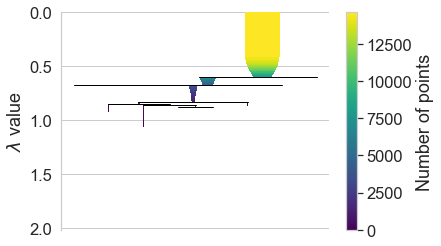

In [12]:
clusterer.condensed_tree_.plot()
plt.show()

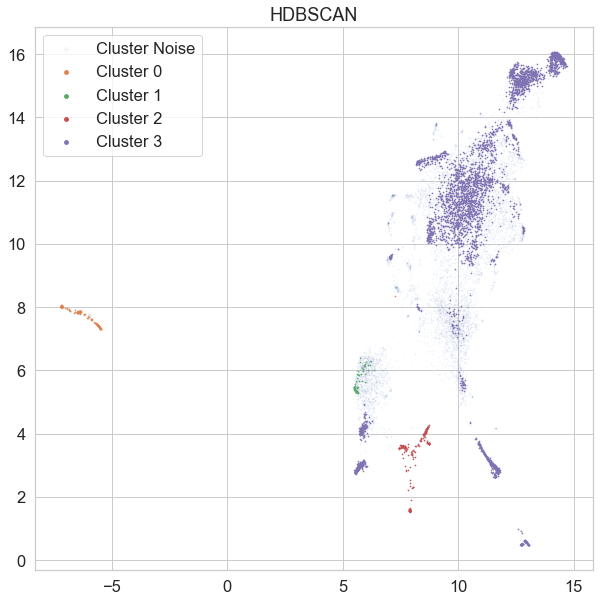


Cluster -1

Negative : 0.602
Neutral : 0.235
Positive : 0.163

* <START> hrs and counting today alone like i do have other things to accomplish today than to just keep

* <START> my tweet gets me a response to email

* <START> wheels up to be exact i sending a


Cluster 0

Neutral : 0.103
Positive : 0.897

* <START> great thank

* <START> thank

* <START> you have the absolute best team and customer service ever every time i fly with you i delighted thank


Cluster 1

Positive : 1.0

* <START> first time flying virgin went to sanfrancisco for the smooth ride easily my new fav

* <START> you my early frontrunner for best

* <START> to all the ground crews working in the cold thanks for what do amp social media team for customer


Cluster 2

Negative : 0.083
Neutral : 0.261
Positive : 0.656

* <START>

* <START>

* <START> i was on flt tomorrow they moved me to i need it moved to tuesday the roads wo be better for flight


Cluster 3

Negative : 0.796
Neutral : 0.118
Positive : 0.086

* 

In [13]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='HDBSCAN',
    embedding=embeddings,
    decoder=decoder,
    pad=0,
    verbose=3,
    s=0.4
)

## Clustering with Affinity Propagation

In [14]:
clusterer = Birch()
clusterer.fit(embeddings)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
      threshold=0.5)

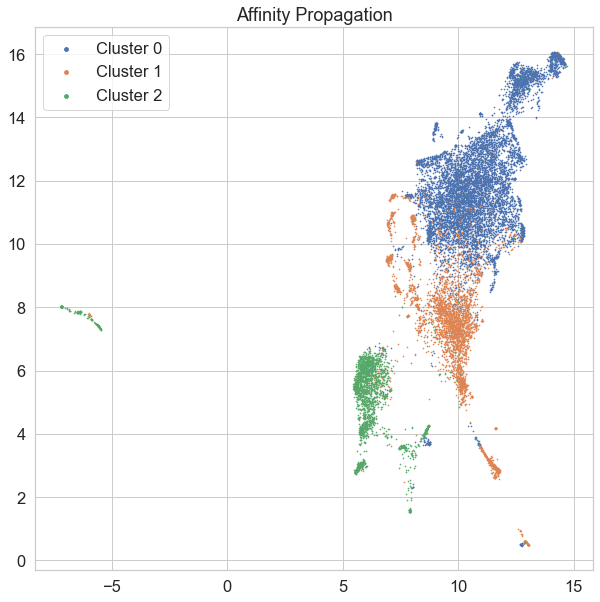


Cluster 0

Negative : 0.977
Neutral : 0.019
Positive : 0.004

* <START> was supposed to be in little rock at this

* <START> your customer service is

* <START> i unable to check in for flight and have heard if flight was cancelled any


Cluster 1

Negative : 0.242
Neutral : 0.724
Positive : 0.033

* <START> i be calling

* <START> was on hold for hours before you disconnected me after my flight was cancelled flightled swell company

* <START> forget wedding fairs how about discounts for nonprofits we donate part of our worth every single


Cluster 2

Negative : 0.011
Neutral : 0.058
Positive : 0.931

* <START> lauren omg best airline

* <START> i was so excited when i saw that you fly there

* <START> thanks to betty working gate at ilm and lovely gate agents here in clt helping me get home phx tonight instead of



In [15]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='Affinity Propagation',
    embedding=embeddings,
    decoder=decoder,
    verbose=3,
    pad=0,
    s=0.4
)

## Clustering Agglomerative

In [16]:
clusterer = AgglomerativeClustering(6)
clusterer.fit(embeddings)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6)

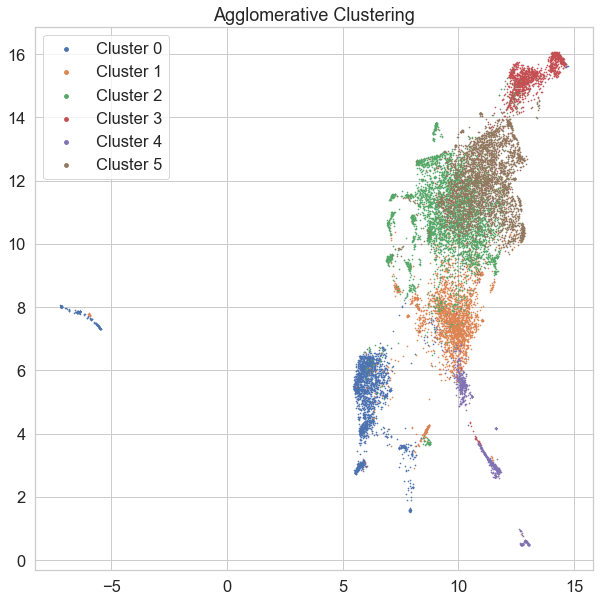


Cluster 0

Negative : 0.017
Neutral : 0.032
Positive : 0.951

* <START> thanks for the reply if you can get me a better seat on my next leg to munich that would be

* <START> the den agent was amazing the mpagent at check in she

* <START> i left my comment with customer care thanks for contacting


Cluster 1

Negative : 0.155
Neutral : 0.811
Positive : 0.035

* <START> please hogs my next flight for me i waiting on a bus to get me off one plane so i can run to the other it leaves in two

* <START> case

* <START>


Cluster 2

Negative : 0.959
Neutral : 0.036
Positive : 0.006

* <START> delayed for two hours at ord gt cdg the one time i need to be there to catch a

* <START> yes please train your customer service agents with correct i should not be receiving different evrytime i

* <START> you ca claim weather with your hardworking crew pulling seats out of a plane do the right thing but we both know you


Cluster 3

Negative : 0.982
Neutral : 0.017
Positive : 0.001

* <START> this da

In [17]:
results  = cluster_inspection(
    manifolds, 
    sentences, 
    sentiments, 
    clusterer.labels_, 
    title='Agglomerative Clustering',
    embedding=embeddings,
    decoder=decoder,
    verbose=3,
    pad=0,
    s=0.4
)